<a href="https://colab.research.google.com/github/ibenatar-96/statistical-rethinking-numpyro/blob/main/chapter_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q numpyro arviz daft networkx
!git clone https://github.com/fehiepsi/rethinking-numpyro.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 2.2 MB/s eta 0:00:00
Cloning into 'rethinking-numpyro'...
remote: Enumerating objects: 1805, done.
remote: Counting objects: 100% (408/408), done.
remote: Compressing objects: 100% (249/249), done.
remote: Total 1805 (delta 209), reused 273 (delta 142), pack-reused 1397
Receiving objects: 100% (1805/1805), 158.83 MiB | 16.07 MiB/s, done.
Resolving deltas: 100% (1228/1228), done.


In [2]:
import collections
import itertools
import math
import os

import arviz as az
import daft
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation


In [3]:
# load data and copy
WaffleDivorce = pd.read_csv("rethinking-numpyro/data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce

# standardize variables
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
print(d["D"].shape)
d.head()

(50,)


,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,A,D
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,1.654205
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.544364
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.610716
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,2.093569
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.927058


In [4]:
d.MedianAgeMarriage.std()

1.2436303013880823

In [5]:
def model(A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bA * A)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_1, optim.Adam(1), Trace_ELBO(), A=d.A.values, D=d.D.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_1 = svi_result.params

100%|██████████| 1000/1000 [00:01<00:00, 717.53it/s, init loss: 2138.6682, avg. loss [951-1000]: 60.6515]


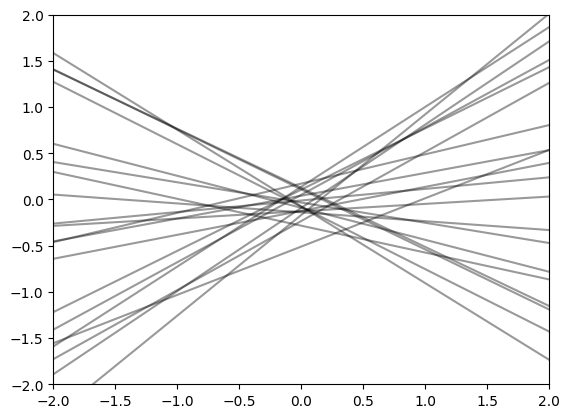

In [6]:
# Define the predictive function with the model m5_1, generating 1000 samples for the parameter "mu"
predictive = Predictive(m5_1.model, num_samples=1000, return_sites=["mu"])

# Generate prior predictions using a random key and fixed values for parameter A
prior_pred = predictive(random.PRNGKey(10), A=jnp.array([-2, 2]))

# Extract the samples of mu from the prior predictions
mu = prior_pred["mu"]

# Create a subplot with specified x and y limits
plt.subplot(xlim=(-2, 2), ylim=(-2, 2))

# Loop over the first 20 samples and plot each mu value as a black line with reduced opacity
for i in range(20):
    plt.plot([-2, 2], mu[i], "k", alpha=0.4)

(1000, 30)


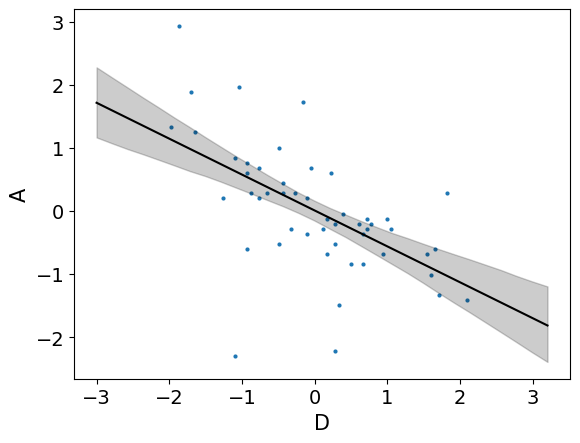

In [7]:
# Compute percentile interval of mean
A_seq = jnp.linspace(start=-3, stop=3.2, num=30)

# Sample from the posterior distribution using the given model and posterior samples
post = m5_1.sample_posterior(random.PRNGKey(1), p5_1, sample_shape=(1000,))
post.pop("mu")  # Remove the "mu" samples from the posterior

# Use predictive to generate posterior predictions for parameter "mu"
post_pred = Predictive(m5_1.model, post)(random.PRNGKey(2), A=A_seq)
mu = post_pred["mu"]
print(mu.shape)

# Calculate the mean and percentile interval of mu
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)

# Plot the data pairs from d
az.plot_pair(d[["D", "A"]].to_dict(orient="list"))

# Plot the mean mu values over A_seq
plt.plot(A_seq, mu_mean, "k")

# Fill the area between the percentile intervals with a semi-transparent black color
plt.fill_between(A_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)

# Display the plot
plt.show()

In [8]:
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())
print(d["M"].shape)

def model(M, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_2, optim.Adam(1), Trace_ELBO(), M=d.M.values, D=d.D.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_2 = svi_result.params

(50,)


100%|██████████| 1000/1000 [00:00<00:00, 1145.83it/s, init loss: 962.7465, avg. loss [951-1000]: 67.4809]


<ipython-input-9-a5323ae084ef>:5: UserWarning: Hessian of log posterior at the MAP point is singular. Posterior samples from AutoLaplaceApproxmiation will be constant (equal to the MAP point). Please consider using an AutoNormal guide.
  post = m5_1.sample_posterior(random.PRNGKey(1), p5_2, sample_shape=(1000,))


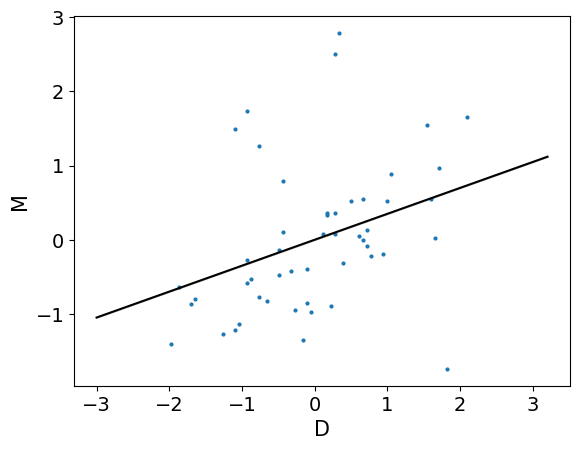

In [9]:
# Compute percentile interval of mean
A_seq = jnp.linspace(start=-3, stop=3.2, num=30)

# Sample from the posterior distribution using the given model and posterior samples
post = m5_1.sample_posterior(random.PRNGKey(1), p5_2, sample_shape=(1000,))
post.pop("mu")  # Remove the "mu" samples from the posterior

# Use predictive to generate posterior predictions for parameter "mu"
post_pred = Predictive(m5_1.model, post)(random.PRNGKey(2), A=A_seq)
mu = post_pred["mu"]

# Calculate the mean and percentile interval of mu
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)

# Plot the data pairs from d
az.plot_pair(d[["D", "M"]].to_dict(orient="list"))

# Plot the mean mu values over A_seq
plt.plot(A_seq, mu_mean, "k")

# Fill the area between the percentile intervals with a semi-transparent black color
plt.fill_between(A_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)

# Display the plot
plt.show()

In [10]:
def model(A, M, D=None):
    alpha = numpyro.sample("alpha", dist.Normal(0, 0.2))
    betaA = numpyro.sample("betaA", dist.Normal(0, 0.5))
    betaM = numpyro.sample("betaM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", alpha + betaA * A + betaM * M)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)

m5_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model, m5_3, optim.Adam(1), Trace_ELBO(), M=d.M.values, A=d.A.values, D=d.D.values
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_3 = svi_result.params
post = m5_3.sample_posterior(random.PRNGKey(1), p5_3, sample_shape=(1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:01<00:00, 902.57it/s, init loss: 6233.2700, avg. loss [951-1000]: 60.7879]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
     alpha     -0.00      0.10     -0.01     -0.16      0.14   1049.96      1.00
     betaA     -0.61      0.16     -0.61     -0.86     -0.36    822.38      1.00
     betaM     -0.06      0.16     -0.06     -0.31      0.19    984.99      1.00
     mu[0]      0.36      0.13      0.37      0.15      0.57    921.63      1.00
     mu[1]      0.32      0.21      0.32     -0.01      0.66    900.77      1.00
     mu[2]      0.12      0.10      0.12     -0.03      0.28    995.35      1.00
     mu[3]      0.76      0.21      0.75      0.43      1.10    911.65      1.00
     mu[4]     -0.35      0.12     -0.35     -0.52     -0.14   1070.56      1.00
     mu[5]      0.12      0.15      0.12     -0.13      0.35    861.01      1.00
     mu[6]     -0.71      0.17     -0.70     -0.95     -0.42   1053.26      1.00
     mu[7]     -0.31      0.20     -0.32     -0.63      0.03    865.14      1.00
     mu[8]     -1.74      0

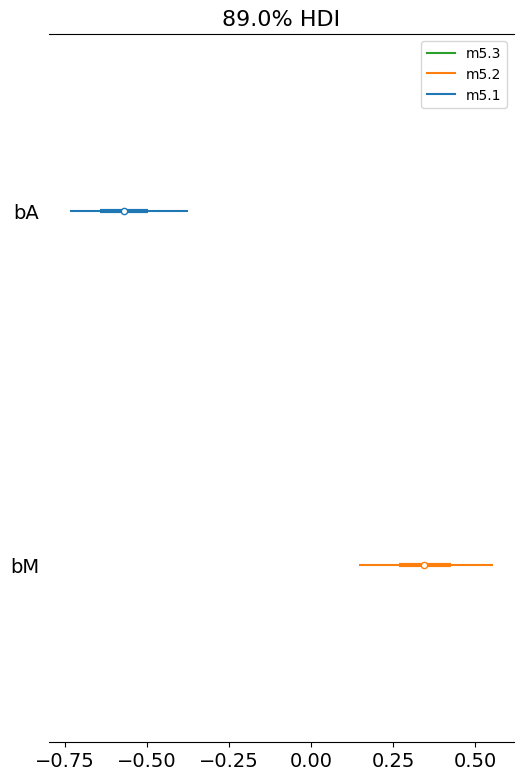

In [11]:
# Dictionary to store posterior samples of coefficients for each model
coeftab = {
    "m5.1": m5_1.sample_posterior(random.PRNGKey(1), p5_1, sample_shape=(1, 1000)),
    "m5.2": m5_2.sample_posterior(random.PRNGKey(2), p5_2, sample_shape=(1, 1000)),
    "m5.3": m5_3.sample_posterior(random.PRNGKey(3), p5_3, sample_shape=(1, 1000)),
}

# Plot a forest plot of the posterior distributions of coefficients
# for each model using ArviZ's plot_forest function
az.plot_forest(
    list(coeftab.values()),  # List of posterior samples for each model
    model_names=list(coeftab.keys()),  # List of model names corresponding to the samples
    var_names=["bA", "bM"],  # Variables (coefficients) to plot from the posterior samples
    hdi_prob=0.89,  # Probability for the highest density interval (HDI)
)

# Display the plot
plt.show()

In [12]:
# Code 5.46

Howell1 = pd.read_csv("rethinking-numpyro/data/Howell1.csv", sep=";")
d = Howell1
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [13]:
# Sample 10,000 values from a normal distribution with mean 178 and standard deviation 20 for female heights
mu_female = dist.Normal(178, 20).sample(random.PRNGKey(0), (int(1e4),))

# Sample 10,000 values from a normal distribution with mean 0 and standard deviation 10 for the difference in heights
diff = dist.Normal(0, 10).sample(random.PRNGKey(1), (int(1e4),))

# Sample 10,000 values from a normal distribution with mean 178 and standard deviation 20 for male heights,
# and add the difference sampled previously to these values
mu_male = dist.Normal(178, 20).sample(random.PRNGKey(2), (int(1e4),)) + diff

# Print a summary of the sampled values for female and male heights with 89% credible interval
print_summary({"mu_female": mu_female, "mu_male": mu_male}, 0.89, False)


                 mean       std    median      5.5%     94.5%     n_eff     r_hat
  mu_female    178.21     20.22    178.24    147.19    211.84   9943.61      1.00
    mu_male    178.10     22.36    178.51    142.35    213.41  10190.58      1.00



In [14]:
d["sex"] = jnp.where(d.male.values == 1, 1, 0)
d.sex

0      1
1      0
2      0
3      1
4      0
      ..
539    1
540    1
541    0
542    1
543    1
Name: sex, Length: 544, dtype: int32

In [17]:
def model(sex, height):
    # Sample intercepts for each unique sex category from a normal distribution with mean 178 and std deviation 20
    a = numpyro.sample("a", dist.Normal(178, 20).expand([len(set(sex))]))

    # Sample standard deviation for the heights from a uniform distribution between 0 and 50
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))

    # Use the sampled intercepts based on the sex of each individual
    mu = a[sex]

    # Define the likelihood of the observed heights given the mu and sigma
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

# Create an AutoLaplaceApproximation object for the model
m5_8 = AutoLaplaceApproximation(model)

# Set up Stochastic Variational Inference (SVI) with the model, approximation, optimizer, and loss function
svi = SVI(model, m5_8, optim.Adam(1), Trace_ELBO(), sex=d.sex.values, height=d.height.values)

# Run SVI for 2000 iterations to fit the model and get the result
svi_result = svi.run(random.PRNGKey(0), 2000)

# Extract the parameters from the SVI result
p5_8 = svi_result.params

# Sample from the posterior distribution using the fitted parameters
post = m5_8.sample_posterior(random.PRNGKey(1), p5_8, sample_shape=(1000,))

# Print a summary of the posterior samples with an 89% credible interval
print_summary(post, 0.89, False)

100%|██████████| 2000/2000 [00:01<00:00, 1607.85it/s, init loss: 5607.9028, avg. loss [1901-2000]: 2584.1577]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]    135.02      1.63    135.07    132.32    137.46    931.50      1.00
      a[1]    142.56      1.73    142.54    140.02    145.51   1111.51      1.00
     sigma     27.32      0.84     27.32     26.03     28.71    951.62      1.00



In [18]:
# Sample from the posterior distribution using the fitted parameters
post = m5_8.sample_posterior(random.PRNGKey(1), p5_8, sample_shape=(1000,))

# Calculate the difference between the intercepts for the first and second sex categories
post["diff_fm"] = post["a"][:, 0] - post["a"][:, 1]

# Print a summary of the posterior samples, including the difference, with an 89% credible interval
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]    135.02      1.63    135.07    132.32    137.46    931.50      1.00
      a[1]    142.56      1.73    142.54    140.02    145.51   1111.51      1.00
   diff_fm     -7.54      2.38     -7.47    -11.77     -4.32    876.56      1.00
     sigma     27.32      0.84     27.32     26.03     28.71    951.62      1.00



In [22]:
milk = pd.read_csv("rethinking-numpyro/data/milk.csv", sep=";")
d = milk
d.clade.unique()
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [25]:
# Convert the 'clade' column in the dataframe 'd' to a categorical type and then to numerical codes
d["clade_id"] = d.clade.astype("category").cat.codes

100%|██████████| 1000/1000 [00:00<00:00, 2144.84it/s, init loss: 94.6847, avg. loss [951-1000]: 36.2487]


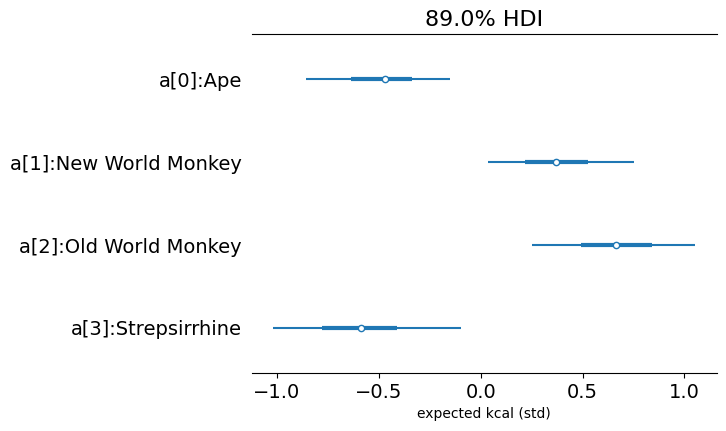

In [26]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())

def model(clade_id, K):
    # Sample intercepts for each unique clade category from a normal distribution with mean 0 and std deviation 0.5
    a = numpyro.sample("a", dist.Normal(0, 0.5).expand([len(set(clade_id))]))

    # Sample standard deviation for the kcal values from an exponential distribution with rate 1
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    # Use the sampled intercepts based on the clade_id of each observation
    mu = a[clade_id]

    # Define the likelihood of the observed standardized kcal values given the mu and sigma
    numpyro.sample("height", dist.Normal(mu, sigma), obs=K)

# Create an AutoLaplaceApproximation object for the model
m5_9 = AutoLaplaceApproximation(model)

# Set up Stochastic Variational Inference (SVI) with the model, approximation, optimizer, and loss function
svi = SVI(model, m5_9, optim.Adam(1), Trace_ELBO(), clade_id=d.clade_id.values, K=d.K.values)

# Run SVI for 1000 iterations to fit the model and get the result
svi_result = svi.run(random.PRNGKey(0), 1000)

# Extract the parameters from the SVI result
p5_9 = svi_result.params

# Sample from the posterior distribution using the fitted parameters
post = m5_9.sample_posterior(random.PRNGKey(1), p5_9, sample_shape=(1000,))

# Create labels for each clade with the corresponding index
labels = ["a[" + str(i) + "]:" + s for i, s in enumerate(sorted(d.clade.unique()))]

# Plot the posterior distributions of the intercepts with 89% credible intervals
az.plot_forest({"a": post["a"][None, ...]}, hdi_prob=0.89)

# Set y-axis tick labels and x-axis label
plt.gca().set(yticklabels=labels[::-1], xlabel="expected kcal (std)")

# Display the plot
plt.show()

In [27]:
# Generate a random key for reproducibility
key = random.PRNGKey(63)

# Assign each row in dataframe 'd' a 'house' value by randomly choosing from the repeated sequence [0, 0, 0, ..., 3, 3, 3]
# The sequence [0, 1, 2, 3] is repeated 8 times and then randomly assigned without replacement to match the shape of 'd'
d["house"] = random.choice(key, jnp.repeat(jnp.arange(4), 8), d.shape[:1], replace=False)

In [28]:
def model(clade_id, house, K):
    # Sample intercepts for each unique clade category from a normal distribution with mean 0 and std deviation 0.5
    a = numpyro.sample("a", dist.Normal(0, 0.5).expand([len(set(clade_id))]))

    # Sample intercepts for each unique house category from a normal distribution with mean 0 and std deviation 0.5
    h = numpyro.sample("h", dist.Normal(0, 0.5).expand([len(set(house))]))

    # Sample standard deviation for the kcal values from an exponential distribution with rate 1
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    # Calculate the mean kcal value using the sampled intercepts for clade and house categories
    mu = a[clade_id] + h[house]

    # Define the likelihood of the observed standardized kcal values given the mu and sigma
    numpyro.sample("height", dist.Normal(mu, sigma), obs=K)

# Create an AutoLaplaceApproximation object for the model
m5_10 = AutoLaplaceApproximation(model)

# Set up Stochastic Variational Inference (SVI) with the model, approximation, optimizer, and loss function
svi = SVI(
    model,
    m5_10,
    optim.Adam(1),
    Trace_ELBO(),
    clade_id=d.clade_id.values,
    house=d.house.values,
    K=d.K.values,
)

# Run SVI for 1000 iterations to fit the model and get the result
svi_result = svi.run(random.PRNGKey(0), 1000)

# Extract the parameters from the SVI result
p5_10 = svi_result.params

100%|██████████| 1000/1000 [00:01<00:00, 802.17it/s, init loss: 491.4240, avg. loss [951-1000]: 36.5554]
